# Fine-tuning

пример кода на PyTorch, который демонстрирует, как использовать предобученную модель и провести ее тонкую настройку (fine-tuning) на новом классе изображений. В данном примере мы используем простейший набор данных MNIST и добавляем новый класс, состоящий из перевернутых изображений цифр.

Пояснение:

Импорт библиотек: импортируем необходимые модули из PyTorch.

Проверка устройства: определяем, есть ли доступ к GPU для ускорения вычислений.

Преобразования данных: используем transforms для изменения размера изображений и преобразования их в тензоры.
Загрузка и расширение датасета:

Загружаем стандартный набор данных MNIST.

Создаем новый класс, переворачивая изображения на 180 градусов.

Объединяем исходный набор данных с новым классом, используя ConcatDataset.

Загрузчик данных: создаем DataLoader для итерации по данным во время обучения.

Модель:

Загружаем предобученную модель ResNet18.

Заменяем последний полностью связанный слой, чтобы он соответствовал количеству наших классов (10 исходных цифр + 1 новый класс).

Функция потерь и оптимизатор: используем кросс-энтропию и стохастический градиентный спуск.

Функция обучения: определяем процесс обучения модели на наших данных.

Обучение модели: запускаем процесс обучения на определенное количество эпох.

Этот пример демонстрирует, как взять существующий набор данных, добавить новый класс и провести тонкую настройку предобученной модели на этих данных с помощью PyTorch.

C:\Users\vahahat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vahahat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха [1/2], Потеря: 0.0689, Точность: 97.89%
Эпоха [2/2], Потеря: 0.0191, Точность: 99.38%


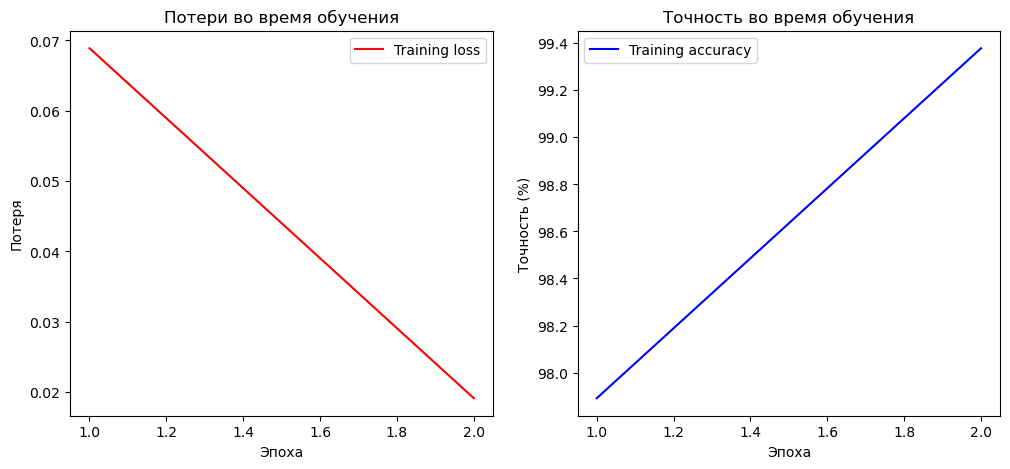

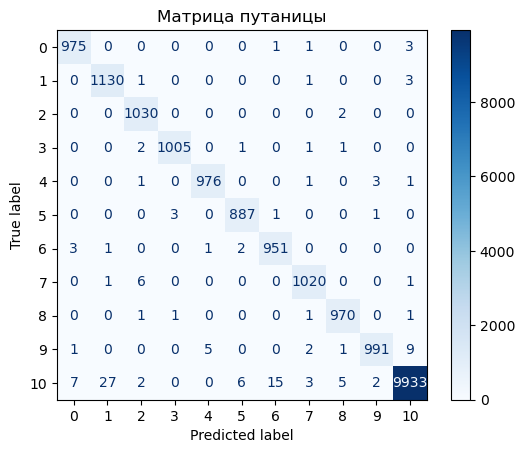

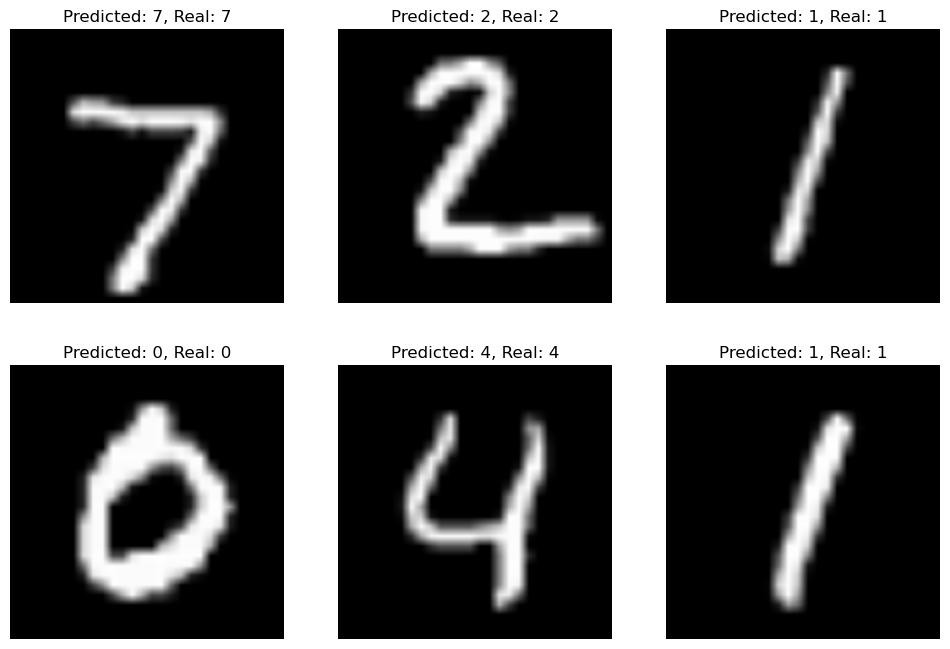

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определяем преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Преобразуем в 3 канала
    transforms.ToTensor(),
])

# Создаем пользовательский датасет для обучения
class ExtendedMNIST(torch.utils.data.Dataset):
#     - **Параметры метода**: `root` - путь для сохранения данных, `train` - флаг для загрузки обучающего или тестового набора, `transform` - преобразования для изображений, `download` - загрузка данных, если они ещё не были загружены.
# - **`self.mnist_dataset`**: загружаем оригинальный датасет MNIST.
# - **`self.num_original`**: сохраняем количество изображений в оригинальном наборе.
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=download)
        self.transform = transform
        self.num_original = len(self.mnist_dataset)

    def __len__(self):
        # Удваиваем длину для включения перевернутых изображений
        return 2 * len(self.mnist_dataset)
    
#     - **`idx`**: индекс элемента, запрашиваемого из датасета.
# - **Если `idx` меньше длины оригинального набора**: возвращаем исходное изображение и метку.
# - **Если `idx` больше или равно длине оригинала**: создаём и возвращаем перевёрнутое изображение. Для этого мы поворачиваем изображение на 180 градусов и назначаем ему новый класс с меткой '10'.
# - **Преобразования**: при наличии применяем к изображению заданные преобразования.

    def __getitem__(self, idx):
        if idx < self.num_original:
            # Исходные изображения
            img, label = self.mnist_dataset[idx]
        else:
            # Перевернутые изображения
            img, _ = self.mnist_dataset[idx - self.num_original]
            img = transforms.functional.rotate(img, 180)
            label = 10  # Новый класс с меткой '10'
        # Применяем преобразования
        if self.transform:
            img = self.transform(img)
        return img, label

# Создаем расширенный тренировочный датасет
train_dataset = ExtendedMNIST(root='./data', train=True, transform=transform, download=True)

# Создаем расширенный тестовый датасет
class ExtendedMNISTTest(torch.utils.data.Dataset):
    def __init__(self, root='./data', transform=None, download=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=False, transform=None, download=download)
        self.transform = transform
        self.num_original = len(self.mnist_dataset)

    def __len__(self):
        # Удваиваем длину для включения перевернутых изображений
        return 2 * len(self.mnist_dataset)

    def __getitem__(self, idx):
        if idx < self.num_original:
            # Исходные изображения
            img, label = self.mnist_dataset[idx]
        else:
            # Перевернутые изображения
            img, _ = self.mnist_dataset[idx - self.num_original]
            img = transforms.functional.rotate(img, 180)
            label = 10  # Новый класс с меткой '10'
        # Применяем преобразования
        if self.transform:
            img = self.transform(img)
        return img, label

# Создаем загрузчики данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = ExtendedMNISTTest(root='./data', transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Загружаем предобученную модель ResNet18
model = models.resnet18(pretrained=True)

# Изменяем последний слой для 11 классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)
model = model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Функция для обучения с сохранением потерь и точности для визуализации
def train_model_with_tracking(model, criterion, optimizer, train_loader, num_epochs):
    train_loss_history = []
    train_accuracy_history = []
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Подсчёт точности
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f'Эпоха [{epoch + 1}/{num_epochs}], Потеря: {epoch_loss:.4f}, Точность: {epoch_accuracy:.2f}%')

    return train_loss_history, train_accuracy_history

# Визуализация потерь и точности
def plot_loss_accuracy(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, 'r', label='Training loss')
    plt.title('Потери во время обучения')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, 'b', label='Training accuracy')
    plt.title('Точность во время обучения')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.legend()

    plt.show()

# Функция для отображения матрицы путаницы и примеров предсказаний
def visualize_predictions(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Матрица путаницы
    cm = confusion_matrix(all_labels, all_predictions, labels=range(11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(11))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Матрица путаницы")
    plt.show()

    # Визуализация нескольких реальных и предсказанных классов
    # Выбираем случайные изображения из тестового набора


    fig = plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = fig.add_subplot(2, 3, i+1)
        img, label = test_dataset[i]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(f'Predicted: {all_predictions[i]}, Real: {label}')
        ax.axis('off')

    plt.show()

# Запуск обучения с отслеживанием метрик
num_epochs = 2  # Вы можете увеличить число эпох для лучшего результата
train_loss_history, train_accuracy_history = train_model_with_tracking(model, criterion, optimizer, train_loader, num_epochs)

# Визуализация графиков потерь и точности
plot_loss_accuracy(train_loss_history, train_accuracy_history)

# Визуализация матрицы путаницы и предсказанных классов
visualize_predictions(model, test_loader)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определяем преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Преобразуем в 3 канала
    transforms.ToTensor(),
])

# Создаем пользовательский датасет
class ExtendedMNIST(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=download)
        self.transform = transform
        self.num_original = len(self.mnist_dataset)

    def __len__(self):
        # Удваиваем длину для включения перевернутых изображений
        return 2 * len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, label = None, None
        if idx < self.num_original:
            # Исходные изображения
            img, label = self.mnist_dataset[idx]
        else:
            # Перевернутые изображения
            img, _ = self.mnist_dataset[idx - self.num_original]
            img = transforms.functional.rotate(img, 180)
            label = 10  # Новый класс с меткой '10'
        # Применяем преобразования
        if self.transform:
            img = self.transform(img)
        return img, label

# Создаем расширенный датасет
train_dataset = ExtendedMNIST(root='./data', train=True, transform=transform, download=True)

# Определяем загрузчик данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Загружаем предобученную модель ResNet18
model = models.resnet18(pretrained=True)

# Изменяем последний слой для 11 классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)
model = model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Функция обучения
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Эпоха {epoch+1}, Потеря: {running_loss/len(loader):.4f}')

# Обучаем модель
train(model, train_loader, criterion, optimizer)


Эпоха 1, Потеря: 0.1191
Эпоха 2, Потеря: 0.0248
Эпоха 3, Потеря: 0.0168
Эпоха 4, Потеря: 0.0116
Эпоха 5, Потеря: 0.0092
